## Run, Don't Read

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import numpy as np
import torch
import gc

from transformers import AutoTokenizer, AutoModelForCausalLM, LlamaTokenizer

print('# of gpus: ', torch.cuda.device_count())

from Pruning.FLAP.lib.prune import prune_flap_modular, CIRCUIT_from_scores, head_wise_pruning_scores
from Pruning.FLAP.models.hf_llama.modeling_llama import LlamaForCausalLM
from Pruning.FLAP.models.hf_gpt.modeling_gpt2 import load_pretrained_llama_style_gpt2
from circuits_PP import *
from Pruning.FLAP.lib.parser import parser


from logger_config import logger

from transformers import (
    AutoConfig,
    GPT2Tokenizer,
    GPT2Config,
    GPT2Model)

from datetime import datetime
import pandas as pd

from dataset.loader import load_dataset
from utils.utils import save_img, create_folder, save_parser_information, save_circuit, store_df
from utils.PatchingMetric import ave_logit_diff
from utils.eval_circuit import *
from utils.Visualization import outline_IoU, outline_IOI, heat_map_sparsity, ROC_curve

# model loader
from utils.model_loader import get_gpt2_adapt_to_llama, load_tokenizer, load_hooked_transformer, load_transformer
from utils.dataset_loader import predict_target_token

import json
import time
from fvcore.nn import FlopCountAnalysis


import matplotlib.pyplot as plt
from utils.config import set_PATH

# of gpus:  1


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Parser

In [3]:
is_notebook = get_ipython()
ipython =  is_notebook is not None

if ipython:
    input_args = [
        
        # ----- model names ------
        #'--model_name=baffo32/decapoda-research-llama-7B-hf',
        '--model_name=gpt2',
        #'--model_name=gpt2',
        #"--model_name=Qwen/Qwen2.5-0.5B",
    


        # ----- FLAP parameters
        '--nsamples=50',  
        '--pruning_ratio=0.68',
        '--remove_heads=134', 
        
        '--metrics=WIFN', 
        '--structure=AL-AM',
        #'--structure=UL-UM',

        #"--prepend_bos",
        "--difference_with=corrupted",

        
        # ---- task ------
        #'--task=GreaterThan',
        '--task=ioi',
        #'--task=GenderedPronouns',
        #'--task=induction',
        #'--task=Docstring',
        
                
        
        # ---- others
        '--seed=239501',
        '--cache_dir=llm_weights',
        "--out_path=res",
        '--device=cuda',

        
        
        # ----- save and plot -----
        "--show",
        #"--save_img",
        #"--save_txt", 
        "--cache_dir=/mnt/lustre/work/eickhoff/esx670/llm_weights'",
        "--out_path=/mnt/lustre/work/eickhoff/esx670/res_final",

        #"--cache_dir=C:/Users/Frauke/Documents/Master/llm_weights'",
        #"--out_path=C:/Users/Frauke/Documents/Master/res/",

    ]


args = parser.parse_args(input_args)

# Setting seeds for reproducibility
np.random.seed(args.seed)
torch.random.manual_seed(args.seed)


result_folder = f"{args.model_name}/{args.task}/FLAP/{args.metrics}/{args.structure}/bos_{args.prepend_bos}/{args.difference_with}/"

if args.out_path == "":
    subfolder = result_folder
else:
    subfolder = args.out_path + result_folder

create_folder(subfolder)

# set path variables:
from utils.config import set_PATH, get_PATH
set_PATH(args.out_path)


create new path /mnt/lustre/work/eickhoff/esx670/res_finalgpt2/ioi/FLAP/WIFN/AL-AM/bos_False/corrupted/


# 1) One Run Through FLAP and Evaluation

### Average Logits of Unpruned model and GT circuit

In [8]:

task_folder = f"{args.out_path}/res/{args.task}/"
torch.cuda.empty_cache()
gc.collect()

# ---- loading model, tokenizer, dataset and GT circuit -----
model_hooked = load_hooked_transformer(args.model_name, device=args.device, cache_dir=args.cache_dir)  
eval_tokenizer = load_tokenizer(args.model_name)           
eval_dataset = load_dataset(
    model_name=args.model_name,
    prepend_bos=args.prepend_bos, 
    task=args.task, 
    tokenizer=eval_tokenizer, 
    N=200,#args.nsamples, 
    device=args.device, 
    seed=193485603,#args.seed+10,
)


print("test that the right token is predicted by the unpruned model under clean distribution")
predict_target_token(model_hooked, eval_dataset, eval_tokenizer, device=args.device, n=1)
print("test that the right token is predicted by the unpruned model under corrupted distribution")
predict_target_token(model_hooked, eval_dataset, eval_tokenizer, device=args.device, n=1,use_corrupted=True)



# ---- Average Logits of Unpruned model -----
with torch.no_grad():
    hooked_gt = model_hooked(eval_dataset.clean_tokens)
    
ave_logit_gt = ave_logit_diff(
    hooked_gt, 
    eval_dataset.correct_answers,
    eval_dataset.wrong_answers,   
    eval_dataset.target_idx.to(args.device),
    task=args.task,
    model_name=args.model_name
    )
    
res_unpruned_model = f"Average logit unpruned model: {ave_logit_gt} \n \n"
print(res_unpruned_model)

gt_circuit_name =  get_circuit_name(args.task)
GT_CIRCUIT = choose_circuit(args.task, args.model_name)

try:
    GT_CIRCUIT = choose_circuit(args.task, args.model_name)
except:
    GT_CIRCUIT={}
#GT_CIRCUIT={}

# ----- Average Logits of the GT circuit ------
gt_circuit_ave_logit, gt_circuit_performance = evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=GT_CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt, 
    task=args.task, 
    model_name=args.model_name
    )

res_ground_truth = print_statics(
    title=f"*********** GT Circuit of {gt_circuit_name} Task **************",
    ave_logit=gt_circuit_ave_logit, 
    performance_achieved=gt_circuit_performance,
    CIRCUIT=GT_CIRCUIT, 
    IOI_CIRCUIT=GT_CIRCUIT
    )
print(res_ground_truth)

# ----- saving ------
if args.save_txt:
    with open(subfolder + "ground_truth.txt", "w") as file:
        file.write(res_unpruned_model)
        file.write(res_ground_truth)


loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
load gpt2 tokenizer
using gpt2 model in IOI dataset
test that the right token is predicted by the unpruned model under clean distribution
Top 10 Predictions
Prompt 0 : Then, Graham and Kate were thinking about going to the office. Graham wanted to give a bone to Kate
 the       | Probability: 0.2389
 Kate      | Probability: 0.0826
 her       | Probability: 0.0604
 his       | Probability: 0.0344
 their     | Probability: 0.0237
 a         | Probability: 0.0143
 Graham    | Probability: 0.0135
 them      | Probability: 0.0127
 someone   | Probability: 0.0099
 those     | Probability: 0.0087


test that the right token is predicted by the unpruned model under corrupted distribution
Top 10 Predictions
Prompt 0 : Then, Rachel and Clark were thinking about going to the office. Alice wanted to give a bone to Kate
 Rachel    | Probability: 0.1826
 the       | Proba

In [9]:
eval_dataset.clean_tokens.shape

torch.Size([200, 21])

### run FLAP

load gpt2 as CasualLLM adapted to the Llama architecture


GPT2Model2Llama has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c_attn.weight -> QKV weights for layer 0
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c

load gpt2 tokenizer
using gpt2 model in IOI dataset
inputs torch.Size([50, 21, 768])


 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size

 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
before torch.Size([768])
after tensor([0.17

 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
before torch.Size([768])
after tensor([ 1.6035,  0.8085,  0.9475, 43.8904,  0.4503,  1.1790,  0.6082,  0.5952,
         0.4320,  0.6127], device='cuda:0')
W metric torch.Size([768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp to

 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size

 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size

 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
before torch.Size([768])
after tensor([0.1736, 0.0841, 0.0391, 0.2264, 0.1294, 0.1051, 0.0887, 0.0867, 0.0780,
        1.4304], device='cuda:0')
W metric torch.Size([768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([

 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size

 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
before torch.Size([768])
after tensor([0.4314, 0.2398, 0.3090, 0.5685, 0.2718, 0.5893, 0.3589, 0.5755, 0.4662,
        0.6198], device='cuda:0')
W metric torch.Size([768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([

 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size

 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size

 ... (more hidden) ...

inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
inp torch.Size([1, 21, 768])
before torch.Size([768])
after tensor([10.5444,  1.1043,  2.5923,  1.3665,  1.4450, 36.5691,  2.3646,  1.0288,
        16.6277,  0.9910], device='cuda:0')
W me


 
*********** Patching Circuit of IOI Circuit Task **************
Average logit difference: 2.5410 
circuit size: 45 
performance achieved: 84.48% 
TPR: 0.00% 
FPR: 100.00% 
Precision: 0.00% 



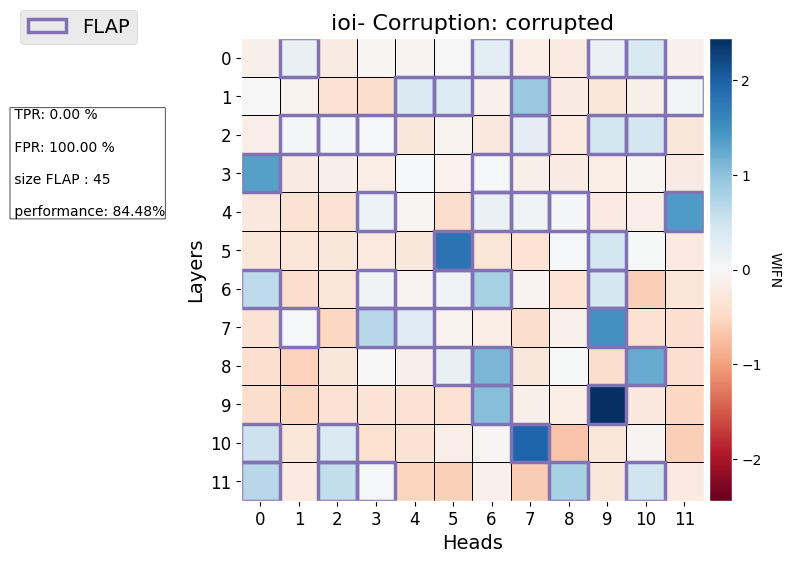

In [14]:
GT_CIRCUIT={}
# Run FLAP
torch.cuda.empty_cache()
gc.collect()

if "gpt2" in args.model_name:
    model = get_gpt2_adapt_to_llama(args.model_name, args.device)
elif "Qwen" in args.model_name:
    model = load_transformer(args.model_name, args.device, cache_dir=args.cache_dir)
tokenizer = load_tokenizer(args.model_name)
  


# ---- run FLAP ------
CIRCUIT, scores, GFLOPS, n_traversed_layers= prune_flap_modular(args, model, tokenizer)
# ----- Evaluate - compare to unpruned model ------
ave_logit, performance = evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=CIRCUIT,    
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt, 
    task=args.task,
    model_name=args.model_name
    )

#gain = performance_gain(performance_new=performance, performance_old=gt_circuit_performance)


res = print_statics(
    title=f"*********** Patching Circuit of {gt_circuit_name} Task **************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT, 
    IOI_CIRCUIT=GT_CIRCUIT
    )
print(res)
        
fig = heat_map_sparsity(
    scores, 
    GT_CIRCUIT,
    CIRCUIT, 
    title=f"{args.task}- Corruption: {args.difference_with}",
    title_eval_circuit="FLAP",
    title_compare_circuit="Path Patching",
    performance=performance,
    print_vals=False,
    title_temp_scale=args.metrics, 
    print_text=True
    )

# 2) Hybrid FLAP

## Test Spatsity Levels and Changes in Performance

In [9]:
torch.cuda.empty_cache()
gc.collect()

# ------ load Causual model ------
if "gpt2" in args.model_name:
    model = get_gpt2_adapt_to_llama(args.model_name, args.device)
    n_layers = model.config.n_layer
    n_heads =  model.config.n_head
elif "Qwen" in args.model_name:
    model = load_transformer(args.model_name, args.device, cache_dir=args.cache_dir)
    n_layers = model.config.num_hidden_layers
    n_heads = model.config.num_attention_heads
    
tokenizer = load_tokenizer(args.model_name)
model_hooked = load_hooked_transformer(model_name=args.model_name, device=args.device)  

# ------ get circuits ------
GT_CIRCUIT = choose_circuit(args.task, args.model_name)
gt_circuit_name =  get_circuit_name(args.task)

# ------ get dataset ------
eval_dataset = load_dataset(
    task=args.task, 
    tokenizer=tokenizer,  
    N=20, 
    patching_method="path", 
    device=args.device, 
    seed=args.seed + 10, 
    prepend_bos=args.prepend_bos
    )

# ------ ave logit of unpruned model ------
with torch.no_grad():
    hooked_gt = model_hooked(eval_dataset.clean_tokens)
    
ave_logit_gt = ave_logit_diff(
    hooked_gt, 
    eval_dataset.correct_answers,
    eval_dataset.wrong_answers,
    eval_dataset.target_idx.to(args.device))

# ------ ave logit of gt circuit ------
gt_circuit_ave_logit, gt_circuit_performance = evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=GT_CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt
    )

res_ground_truth = print_statics(
    title=f"*********** GT Circuit of {gt_circuit_name} Task **************",
    ave_logit=gt_circuit_ave_logit, 
    performance_achieved=gt_circuit_performance,
    CIRCUIT=GT_CIRCUIT, 
    IOI_CIRCUIT=GT_CIRCUIT
    )

print("\n \n", res_ground_truth, "\n \n")

# ------ headwise FLAP pruning scores ------
scores, mlp_scores, mlp_mask, W_metric_unstand_list, GFLOPS, n_traversed_layers = head_wise_pruning_scores(args, model, tokenizer)


load gpt2 as CasualLLM adapted to the Llama architecture


GPT2Model2Llama has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c_attn.weight -> QKV weights for layer 0
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c

load gpt2 tokenizer
loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/path/automatic/logits_diff/sqrt/min_threshold-0.02/k_2-scale_2/
Load GreaterThan with gpt2


IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [20], [20], [20, 89]

In [177]:
# some parameters to set
ave_logit_old = gt_circuit_ave_logit
TOTAL_FLOPS = GFLOPS

# test different sparsity values for the calculated scores, resulting in different CIRCUITS that can be found via FLAP
# evaluate each of these Circuits and save the results
results = pd.DataFrame(columns=["sparsity_ratio", "res", "performance", "gain", "diff", "TPR"])

for i in range(args.lowest_sparsity - args.step_size, args.highest_sparsity, args.step_size):
    args.pruning_ratio = i / 100
    CIRCUIT, _, temp_FLOPS = CIRCUIT_from_scores(
        args, 
        attn_metric_list=scores, 
        W_metric_unstand_list=W_metric_unstand_list, 
        mlp_metric_list=mlp_scores, 
        mlp_mask=mlp_mask,
        FLOPS=GFLOPS, 
        n_layers=n_layers, 
        n_heads=n_heads, 
        head_dim=model_hooked.cfg.d_head
        )
    TOTAL_FLOPS += temp_FLOPS
    
    ave_logit, performance = evaluate_circiut(
        model = model_hooked, 
        CIRCUIT=CIRCUIT,
        dataset=eval_dataset,
        ave_logit_gt=ave_logit_gt
        )

    gain = performance_gain(performance_new=performance, performance_old=gt_circuit_performance)
    diff = ave_logit_old - ave_logit
        
    TPR = get_intersection_num(CIRCUIT, GT_CIRCUIT)
    
    print(f"sparsity_ratio: {args.pruning_ratio}, ave_logit_diff: {ave_logit}, performance: {performance}, gain {gain}, diff: {diff}, TPR:{TPR}")
    new_col = pd.DataFrame({"sparsity_ratio":args.pruning_ratio, "res":ave_logit, "performance":performance, "gain":gain, "diff":diff, "TPR":TPR}, index=[0])
    results = pd.concat([results, new_col], ignore_index=True)
    
    ave_logit_old = ave_logit
    
# write to permanent memory
if args.save_txt:
    print("saving at", subfolder + filename + ".xlsx")
    results.to_excel(subfolder + filename + ".xlsx", index=False)
    save_parser_information(args, subfolder, "save_parser_information.json")
    
    

sparsity_ratio: -0.01, ave_logit_diff: 4.1484375, performance: 100.37807183364839, gain 3.4079844206426477, diff: -0.13671875, TPR:9
sparsity_ratio: 0.0, ave_logit_diff: 4.1484375, performance: 100.37807183364839, gain 3.4079844206426477, diff: 0.0, TPR:9
sparsity_ratio: 0.01, ave_logit_diff: 4.12890625, performance: 99.9054820415879, gain 2.921129503407986, diff: 0.01953125, TPR:9


/tmp/ipykernel_2692376/3751768869.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_col], ignore_index=True)


sparsity_ratio: 0.02, ave_logit_diff: 4.12890625, performance: 99.9054820415879, gain 2.921129503407986, diff: 0.0, TPR:9
sparsity_ratio: 0.03, ave_logit_diff: 4.125, performance: 99.8109640831758, gain 2.8237585199610535, diff: 0.00390625, TPR:9
sparsity_ratio: 0.04, ave_logit_diff: 3.8046875, performance: 92.06049149338375, gain -5.16066212268743, diff: 0.3203125, TPR:8
sparsity_ratio: 0.05, ave_logit_diff: 3.837890625, performance: 92.86389413988658, gain -4.333008763388505, diff: -0.033203125, TPR:8
sparsity_ratio: 0.06, ave_logit_diff: 3.685546875, performance: 89.17769376181474, gain -8.130477117818897, diff: 0.15234375, TPR:7
sparsity_ratio: 0.07, ave_logit_diff: 3.66796875, performance: 88.7523629489603, gain -8.568646543330093, diff: 0.017578125, TPR:7
sparsity_ratio: 0.08, ave_logit_diff: 3.701171875, performance: 89.55576559546314, gain -7.7409931840311526, diff: -0.033203125, TPR:7
sparsity_ratio: 0.09, ave_logit_diff: 3.69140625, performance: 89.31947069943288, gain -7.984

In [178]:
import matplotlib.pyplot as plt
from utils.Visualization import save_image, ROC_curve

y_variable = "performance"

cliff_idx =  - 1
average_window=5
window = 10


### Find Cliffs 

In [175]:
from utils.utils import read_df
print(subfolder)
#results = read_df(subfolder, "clean_table.xlsx" )
results = read_df(subfolder, "ablated_table.xlsx" )

/mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GenderedPronouns/Hybrid-FLAP/smooth_first/sparsity-min_0/sparsity-max_99
DataFrame saved as ablated_table.xlsx at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GenderedPronouns/Hybrid-FLAP/smooth_first/sparsity-min_0/sparsity-max_99


### Biggest Drop

drops [11.625708884688095, 11.625708884688095, 11.342155009451801, 11.436672967863899, 11.342155009451801, 3.5916824196597474, 4.395085066162579, 0.708884688090734, 0.2835538752362936, 1.0869565217391397, 0.9451795841209787, 0.18903591682419574, 0.09451795841209787, 1.606805293005678, 6.852551984877138, 6.947069943289236, 15.642722117202254, 16.02079395085066, 15.500945179584107, 17.013232514177687, 17.627599243856324, 17.627599243856324, 17.296786389413995, 12.996219281663514, 18.714555765595456, 9.688090737240081, 9.924385633270326, 10.349716446124766, 7.466918714555767, 9.688090737240081, 7.514177693761816, 7.230623818525508, 6.568998109640823, 0.4253308128544404, 0.8034026465028248, 0.33081285444234254, 0.7561436672967758, 0.47258979206048224, 0.0, 1.7485822306238177, 0.803402646502839, 0.6616257088846922, 0.09451795841209076, 0.0, 0.18903591682418153, 0.0, 0.0, 0.0, 0.0, 1.8431001890359084, 2.5992438563327056, 17.391304347826086, 15.595463137996212, 16.20982986767485, 16.351606805

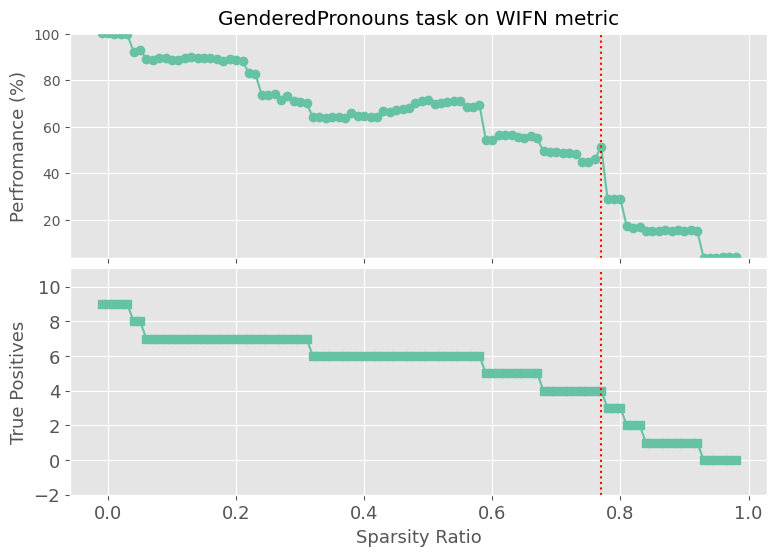

In [179]:
import matplotlib.pyplot as plt
from utils.Visualization import save_image, ROC_curve
import matplotlib.pyplot as plt



def biggest_cliff(results):
    drops = []
    for i in range(0, len(results)-window):
        drops.append(abs(results[i] - min(results[i:i+window])))
    print("drops", drops)
    max_drop = max(drops)
    cliff_idx = drops.index(max_drop)
    return cliff_idx

cliff_idx= biggest_cliff(results[y_variable].values)
print(cliff_idx)

fig = ROC_curve(results, results[y_variable], cliff_value=cliff_idx, title=f"{args.task} task on {args.metrics} metric")
fig.show()
if args.save_img:
    save_image(fig, name=f"cliffs-biggestDrop-stepSize_{args.step_size}", subfolder=subfolder)
    

### Cliff with window function

In [169]:
max_drop=0
cliff_idx=-1
window=10
drop_threshold = 0.1

for i in range(0, len(results)-window):
    drop = abs(results[y_variable][i] - min(results[y_variable][i+1:i+window+1]))
    
    if drop > max_drop and drop >= drop_threshold:
        max_drop = drop
        cliff_idx = i
        
print("cliff at", results["sparsity_ratio"][cliff_idx])

fig = ROC_curve(results, results[y_variable], cliff_idx=cliff_idx, title=f"{args.task} task on {args.metrics} metric")

if args.save_img:
    save_image(fig, name=f"cliffs-window-stepSize_{args.step_size}", subfolder=subfolder)
    
    

cliff at 0.71


TypeError: ROC_curve() got an unexpected keyword argument 'cliff_idx'

### Cliff with moving average

In [ ]:
import numpy as np

def moving_average(data, window):
    averaged = []
    for i in range(0, len(data)):
        window_start = max(0, i - window + 1)
        window_data = data[window_start : i+1]
        averaged_value = np.mean(window_data)
        #print(averaged_value)
        averaged.append(averaged_value)
    return averaged

In [ ]:
average_window=2

smooth_data = moving_average(results[y_variable], window=average_window)
max_drop=0

for i in range(0, len(smooth_data)-window):
    drop = abs(smooth_data[i] - min(smooth_data[i+1:i+window+1]))
    drop = drop / 100
    if drop > max_drop and drop >= drop_threshold:
        max_drop = drop
        cliff_idx = i
        

print("cliff at", results["sparsity_ratio"][cliff_idx])

fig = ROC_curve(results, results[y_variable], cliff_idx=cliff_idx, title=f"{args.task} task on {args.metrics} metric")
#plt.show()

if args.save_img:
    save_image(fig, name=f"cliffs-MovingAverage-stepSize_{args.step_size}", subfolder=subfolder)


### First Cliff

In [ ]:
max_drop=0
window=1
for i in range(0, len(results)-window):
    drop = abs(results[y_variable][i] - min(results[y_variable][i+1:i+window+1]))
    drop = drop / 100
    if drop > max_drop and drop >= drop_threshold:
        max_drop = drop
        cliff_idx = i
        # check for valley:

        if results[y_variable][i] > max(results[y_variable][i+1:]):
        
            break
        
print("cliff at", results["sparsity_ratio"][cliff_idx])

fig = ROC_curve(results, results[y_variable], cliff_idx=cliff_idx, title=f"{args.task} task on {args.metrics} metric")

if args.save_img:
    save_image(fig, name=f"cliffs-FirstCliff-stepSize_{args.step_size}", subfolder=subfolder)


### First Cliff + Moving Averages

In [ ]:
average_window=10
drop_threshold=0.2
window=10
max_drop=0

smooth_data = moving_average(results[y_variable], window=average_window)
len(smooth_data)
for i in range(0, len(smooth_data)-window):
    drop = smooth_data[i] - min(smooth_data[i+1:i+window])
    drop = drop / 100
    
    if drop > max_drop and drop >= drop_threshold:
        max_drop = drop
        cliff_idx = i
        # check for valley:
        if results[y_variable][i] > max(results[y_variable][i:]):
            print("break")
            break
        
print("cliff at", results["sparsity_ratio"][cliff_idx])

fig = ROC_curve(results, smooth_data, cliff_idx=cliff_idx, title=f"{args.task} task on {args.metrics} metric")

if args.save_img:
    save_image(fig, name=f"cliffs_FirstCliffAndMovingAverage_stepSize-{args.step_size}", subfolder=subfolder)


## All in one

In [34]:
torch.cuda.empty_cache()
gc.collect()

#################### Parser #####################################

is_notebook = get_ipython()
ipython =  is_notebook is not None

if ipython:
    input_args = [
        #'--model=baffo32/decapoda-research-llama-7B-hf',
        #'--model_name=gpt2-large',
        #"--model_name=Qwen/Qwen2.5-7B",
        #"--model_name=Qwen/Qwen2.5-0.5B",
        '--model_name=gpt2',
        '--seed=239501',
        '--nsamples=200',  
        '--batch_size=200',
        '--metrics=WIFN', 
        '--structure=AL-AM',
        #'--cache_dir=/mnt/lustre/work/eickhoff/esx670/llm_weights',
        "--step_size=1",
        "--lowest_sparsity=60", 
        "--highest_sparsity=99",
        "--cliff_type=smooth_first",        
        #"--cliff_type=biggest",
        
        #'--task=GreaterThan',
        #'--task=ioi',
        #'--task=GenderedPronouns',
        '--task=induction',
        #"--task=Docstring",
        
        '--device=cuda',
        "--out_path=/mnt/lustre/work/eickhoff/esx670/res_final/",
        "--cache_dir=/mnt/lustre/work/eickhoff/esx670/llm_weights/",
        #'--prepend_bos',
        "--show",
       
        "--save_img", 
        "--save_txt",
        #"--calc_FLOP", 
        "--verbose",
        "--difference_with=corrupted"

    ]


args = parser.parse_args(input_args)
device = args.device

# Setting seeds for reproducibility
np.random.seed(args.seed)
torch.random.manual_seed(args.seed)


result_folder =  f"{args.model_name}/{args.task}/Hybrid-FLAP/{args.cliff_type}/sparsity-min_{args.lowest_sparsity}/sparsity-max_{args.highest_sparsity}"#/step-size_{args.step_size}"

if args.out_path == "":
    subfolder = result_folder
else:
    subfolder = args.out_path + result_folder

create_folder(subfolder)
set_PATH(args.out_path)
y_variable = "performance"

DataFrame saved as ablated_table.xlsx at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Hybrid-FLAP/biggest/sparsity-min_0/sparsity-max_99
DataFrame saved as clean_table.xlsx at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Hybrid-FLAP/biggest/sparsity-min_0/sparsity-max_99


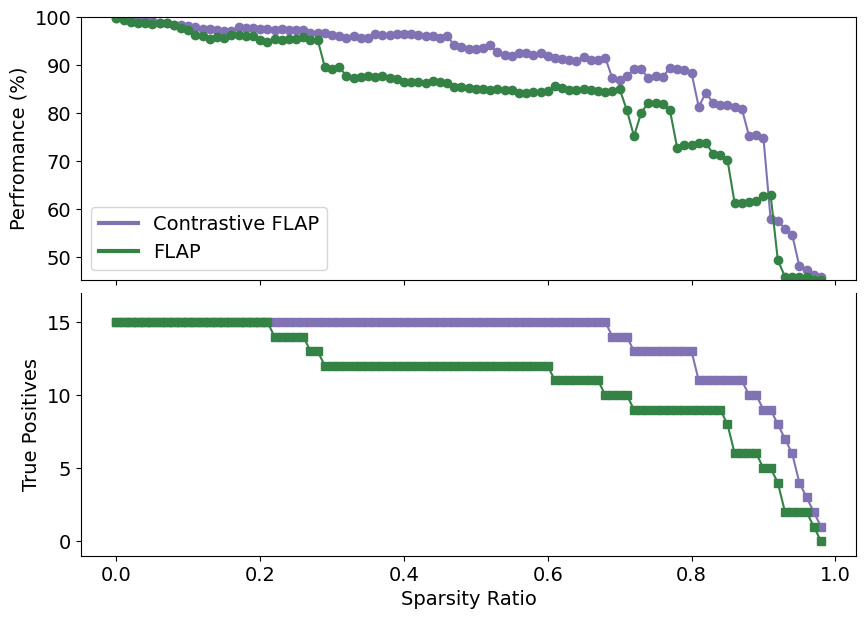

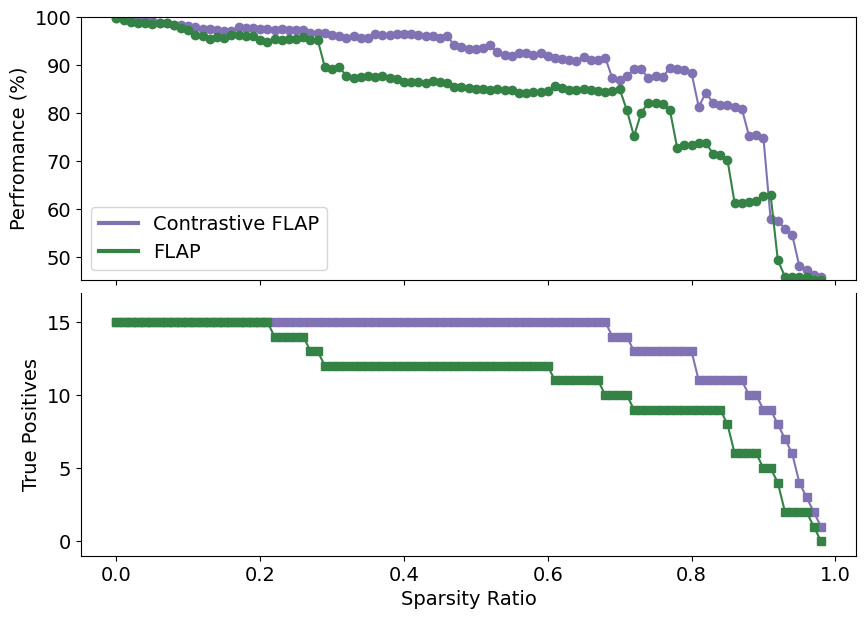

In [39]:
from utils.utils import load_df, read_df
from utils.Visualization import two_ROC_curve
corr_data = read_df(f"/mnt/lustre/work/eickhoff/esx670/res_final/{args.model_name}/{args.task}/Hybrid-FLAP/biggest/sparsity-min_0/sparsity-max_99", "ablated_table.xlsx")
clean_data = read_df(f"/mnt/lustre/work/eickhoff/esx670/res_final/{args.model_name}/{args.task}/Hybrid-FLAP/biggest/sparsity-min_0/sparsity-max_99", "clean_table.xlsx")

two_ROC_curve(corr_data, corr_data["performance"], None, clean_data, clean_data["performance"], None, "", p1=None, p2=None)

DataFrame saved as clean_table.xlsx at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2-large/induction/Pruning/first/sparsity-min_60/
110.15196811160936
drop threshold 11.015196811160937
idx 12
results 93.77179870453413


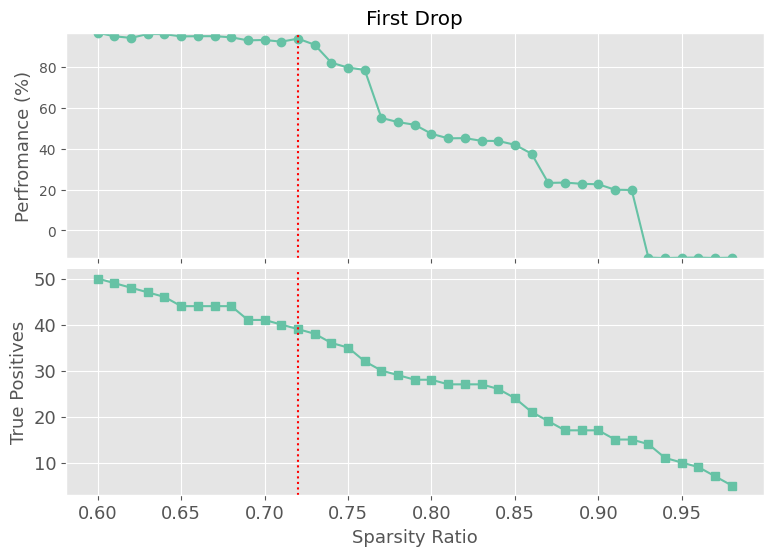

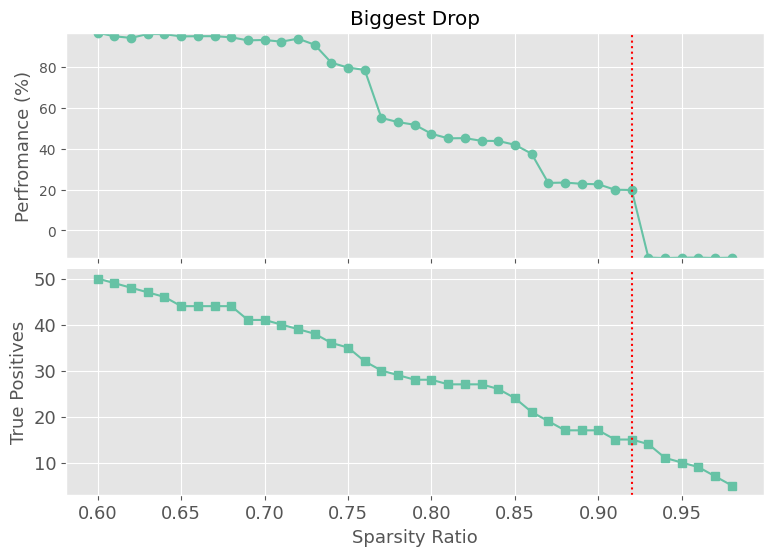

In [76]:
from Pruning.FLAP.lib.FLAP_largeModels import first_cliff, biggest_cliff
corr_data = read_df("/mnt/lustre/work/eickhoff/esx670/res_final/gpt2-large/induction/Pruning/first/sparsity-min_60/", "clean_table.xlsx")

y_variable = "performance"
results_corr_loop = corr_data[(corr_data["sparsity_ratio"] >= 60 / 100) & (corr_data["sparsity_ratio"] < 99 / 100)]
performance_metric = results_corr_loop[y_variable].tolist()



window=round((99-60) / 10)
average_window = window

max_diff = max(results_corr_loop[y_variable]) - min(results_corr_loop[y_variable])
print(max_diff)

drop_threshold=max_diff / 10 #(max_diff/250) * 0.5 -((10-average_window)/100)
print("drop threshold", drop_threshold)
slope_threshold=-drop_threshold
cliff_idx = first_cliff(performance_metric, window=window, drop_threshold=drop_threshold)

if cliff_idx==-1:
    corr_cliff = 0.75
else:
    corr_cliff = results_corr_loop["sparsity_ratio"].iloc[cliff_idx]
fig1 = ROC_curve(results_corr_loop, performance_metric, cliff_value=corr_cliff, title=f"First Drop")



cliff_idx = biggest_cliff(performance_metric, window=window, drop_threshold=drop_threshold)

if cliff_idx==-1:
    corr_cliff = 0.75
else:
    corr_cliff = results_corr_loop["sparsity_ratio"].iloc[cliff_idx]
fig1 = ROC_curve(results_corr_loop, performance_metric, cliff_value=corr_cliff, title=f"Biggest Drop")


load gpt2 as CasualLLM adapted to the Llama architecture


GPT2Model2Llama has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


load gpt2 tokenizer
Loading Induction Dataset with gpt2


 ... (more hidden) ...


Loading Induction Dataset with gpt2


 ... (more hidden) ...


loading gpt2 as HookedTransformer
use float 16


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
Loading Induction Dataset with gpt2
path /mnt/lustre/work/eickhoff/esx670/res_final//gpt2/induction/path/automatic/logits_diff/sqrt/min_threshold-0.002/k_2-scale_2.5/
path /mnt/lustre/work/eickhoff/esx670/res_final//gpt2/induction/path/automatic/logits_diff/sqrt/min_threshold-0.002/k_2-scale_2.5/

 
*********** GT Circuit of Induction Circuit Task **************
Average logit difference: 14.0078 
circuit size: 22 
performance achieved: 92.47% 
TPR: 100.00% 
FPR: 0.00% 
Precision: 100.00% 

sparsity_ratio: 0.6, ave_logit_diff: 12.6953125, performance: 83.80608561113976, gain -9.369771332961513, diff: 1.3125, TPR:18


/mnt/lustre/home/eickhoff/esx670/OverlapMetric/Pruning/FLAP/lib/FLAP_largeModels.py:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_col], ignore_index=True)


sparsity_ratio: 0.61, ave_logit_diff: 12.8359375, performance: 84.73439917483239, gain -8.365867261572777, diff: -0.140625, TPR:17
sparsity_ratio: 0.62, ave_logit_diff: 12.796875, performance: 84.47653429602887, gain -8.644729503625213, diff: 0.0390625, TPR:17
sparsity_ratio: 0.63, ave_logit_diff: 12.65625, performance: 83.54822073233626, gain -9.648633575013934, diff: 0.140625, TPR:17
sparsity_ratio: 0.64, ave_logit_diff: 12.65625, performance: 83.54822073233626, gain -9.648633575013934, diff: 0.0, TPR:17
sparsity_ratio: 0.65, ave_logit_diff: 12.6875, performance: 83.75451263537906, gain -9.425543781372001, diff: -0.03125, TPR:17
sparsity_ratio: 0.66, ave_logit_diff: 12.6640625, performance: 83.59979370809695, gain -9.592861126603458, diff: 0.0234375, TPR:17
sparsity_ratio: 0.67, ave_logit_diff: 12.6015625, performance: 83.18720990201135, gain -10.039040713887335, diff: 0.0625, TPR:17
sparsity_ratio: 0.68, ave_logit_diff: 12.640625, performance: 83.44507478081485, gain -9.760178471834

/mnt/lustre/home/eickhoff/esx670/OverlapMetric/Pruning/FLAP/lib/FLAP_largeModels.py:202: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_col], ignore_index=True)


sparsity_ratio: 0.61, ave_logit_diff: 13.7578125, performance: 90.82001031459515, gain -1.784718349135524, diff: 0.0390625, TPR:20
sparsity_ratio: 0.62, ave_logit_diff: 13.703125, performance: 90.45899948427024, gain -2.175125488008926, diff: 0.0546875, TPR:20
sparsity_ratio: 0.63, ave_logit_diff: 13.6484375, performance: 90.09798865394534, gain -2.5655326268823124, diff: 0.0546875, TPR:20
sparsity_ratio: 0.64, ave_logit_diff: 13.6171875, performance: 89.89169675090253, gain -2.788622420524259, diff: 0.03125, TPR:20
sparsity_ratio: 0.65, ave_logit_diff: 13.7578125, performance: 90.82001031459515, gain -1.784718349135524, diff: -0.140625, TPR:20
sparsity_ratio: 0.66, ave_logit_diff: 13.625, performance: 89.94326972666323, gain -2.732849972113769, diff: 0.1328125, TPR:20
sparsity_ratio: 0.67, ave_logit_diff: 13.625, performance: 89.94326972666323, gain -2.732849972113769, diff: 0.0, TPR:20
sparsity_ratio: 0.68, ave_logit_diff: 13.7109375, performance: 90.51057246003094, gain -2.119353039

GPT2Model2Llama has generative capabilities, as `prepare_inputs_for_generation` is explicitly defined. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c_attn.weight -> QKV weights for layer 0
INFO:shared_logger:Splitting and mapping: transformer.h.0.attn.c

INIT_FLOPS 0.0
INIT COMP TIME 44.372031450271606
cliff function first
INIT_COMP_TIME 44.372031450271606
cliff first from 60 to 99
window 4
clean thresholds
drop_threshold 3.9608045384218675
slope_threshold -0.1921609076843736
idx 9
results 83.54822073233626
DataFrame saved as clean_table.xlsx at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/
out_path gpt2/induction/Pruning/half_life
create new path gpt2/induction/Pruning/half_life
file path gpt2/induction/Pruning/half_life/half_life_clean
fig Figure(900x600)
save img at gpt2/induction/Pruning/half_life/half_life_clean
out_path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/
file path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/clean_ROC
fig Figure(900x600)
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/clean_ROC
cliff at 0.71
Loading Induction Dataset with gp

 ... (more hidden) ...



 
*********** FLAP Circuit vs GT Circuit **************
Average logit difference: 12.1875 
circuit size: 41 
performance achieved: 80.45% 
TPR: 72.73% 
FPR: 60.98% 
Precision: 39.02% 
performance gain -12.99% 
 



/mnt/lustre/home/eickhoff/esx670/OverlapMetric/Pruning/FLAP/lib/FLAP_largeModels.py:524: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_results = pd.concat([final_results, new_res_col], ignore_index=True)


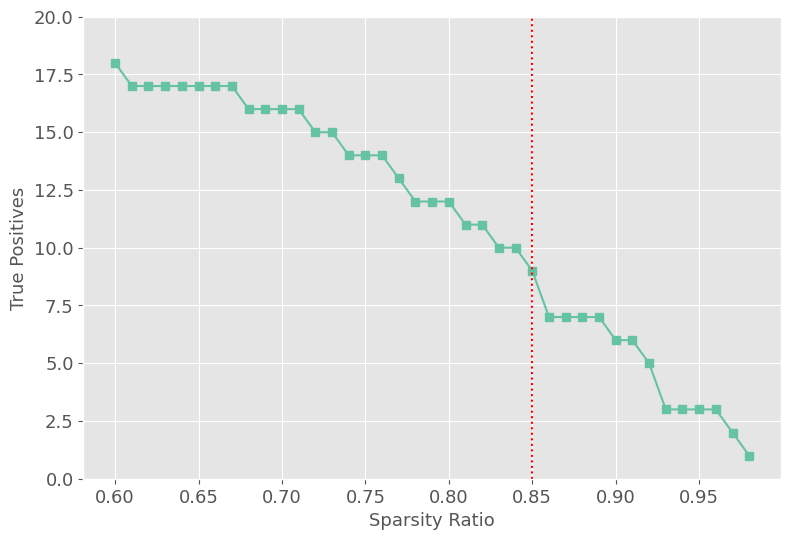

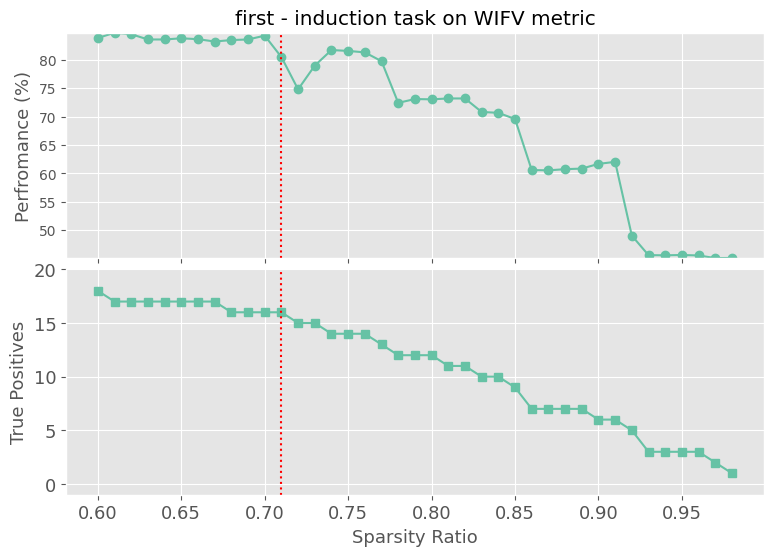

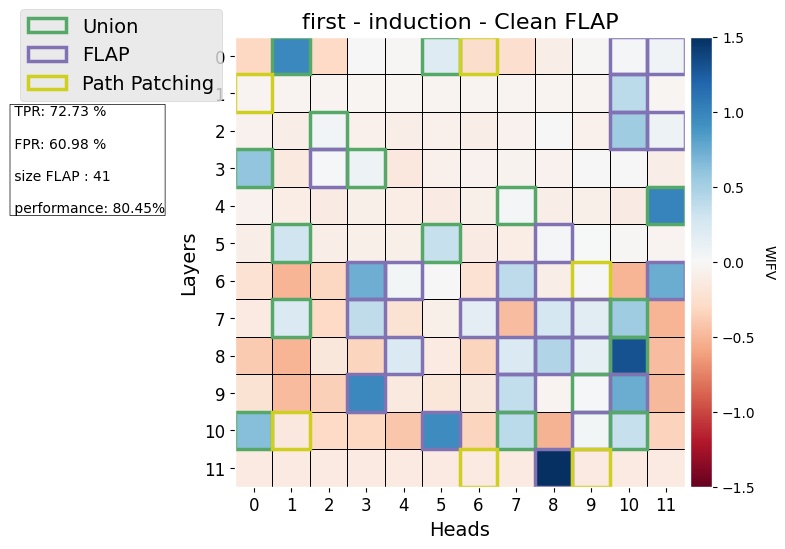

out_path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/
file path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/clean_heatmap.png
fig Figure(900x900)
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/clean_heatmap.png
saving circuit at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/clean_circuit.txt
FLOPS after clean 0.0
elapsed time for clean loop 5.1015214920043945
corrupted thresholds
drop_threshold 4.5384218669417224
slope_threshold -0.3076843733883444
idx 8
results 90.51057246003094
DataFrame saved as ablated_table.xlsx at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/
out_path /mnt/lustre/work/eickhoff/esx670/res_final//gpt2/induction/Pruning/half_life
create new path /mnt/lustre/work/eickhoff/esx670/res_final//gpt2/induction/Pruning/half_life
file path /mnt/lustre/w

 ... (more hidden) ...



 
*********** FLAP CIrcuit vs GT Circuit **************
Average logit difference: 13.7109 
circuit size: 45 
performance achieved: 90.51% 
TPR: 90.91% 
FPR: 55.56% 
Precision: 44.44% 
performance gain -2.12% 
 



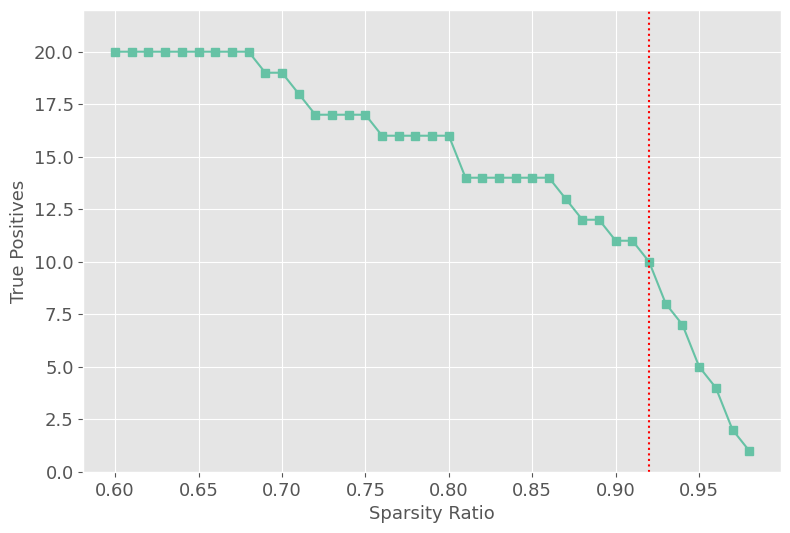

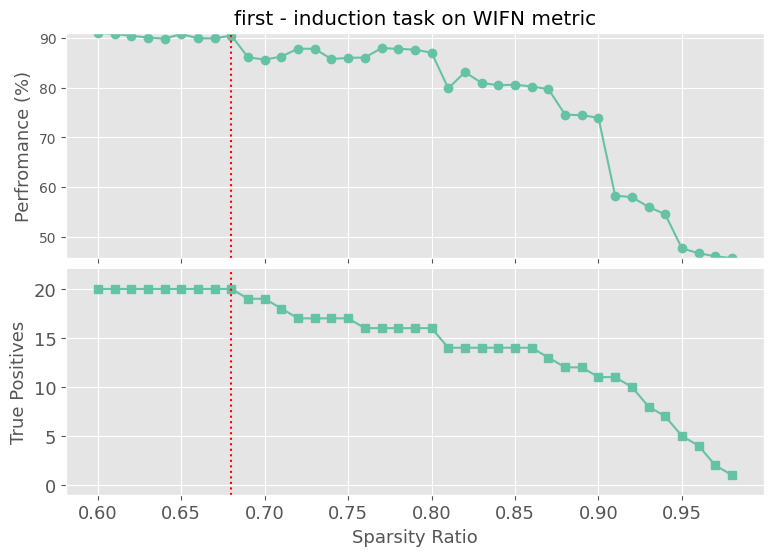

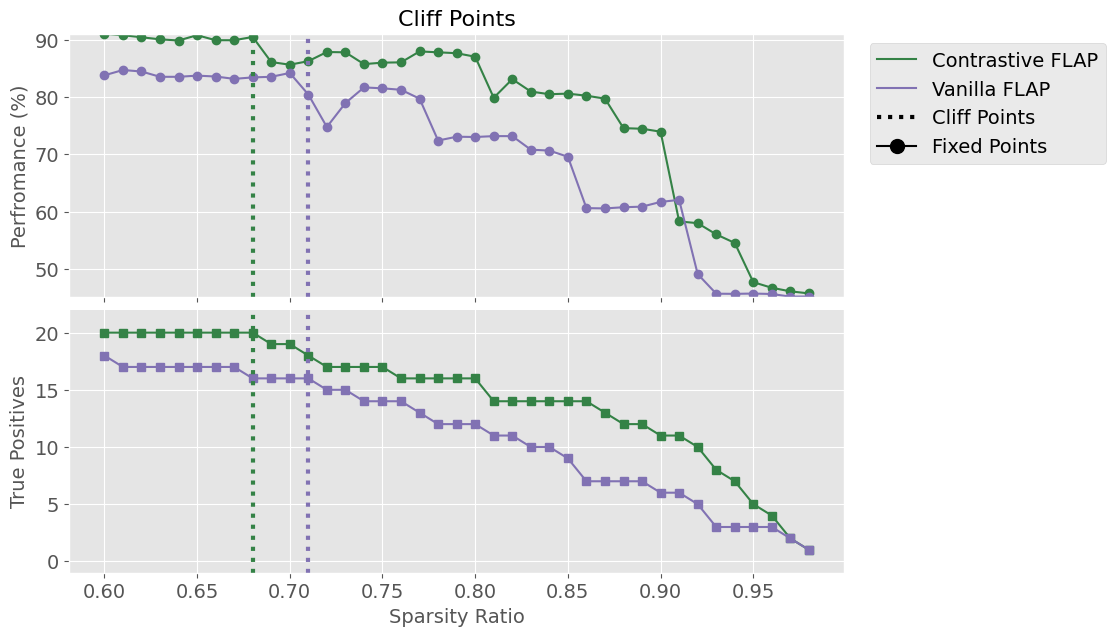

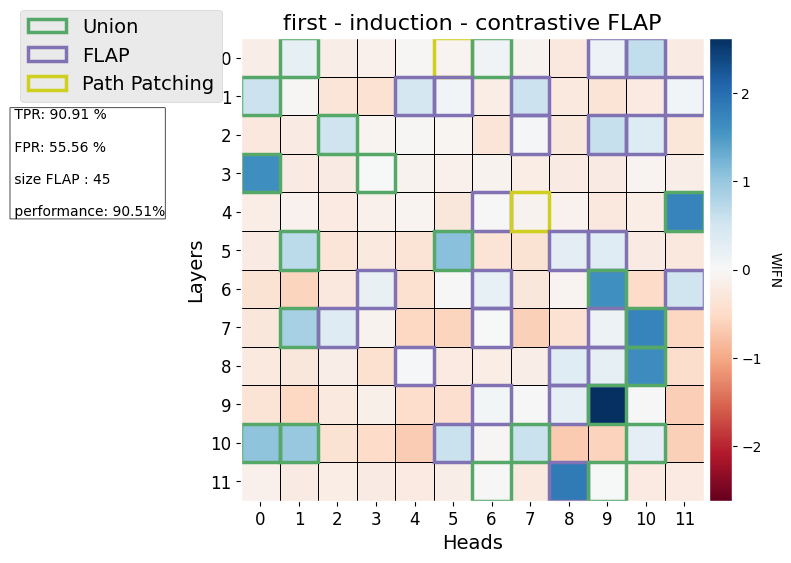

out_path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/
file path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/contrastive_heatmap.png
fig Figure(900x900)
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/contrastive_heatmap.png
saving circuit at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/contrastive_circuit.txt
FLOPS after corrupted 0.0
elapsed time for loop 5.628703355789185
out_path /mnt/lustre/work/eickhoff/esx670/res_final//gpt2/induction/Pruning/half_life
file path /mnt/lustre/work/eickhoff/esx670/res_final//gpt2/induction/Pruning/half_life/induction_two_TP.png
fig Figure(900x600)
save img at /mnt/lustre/work/eickhoff/esx670/res_final//gpt2/induction/Pruning/half_life/induction_two_TP.png
saving circuit at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/induction/Pruning/first/sparsity-min_60/hybrid_cir

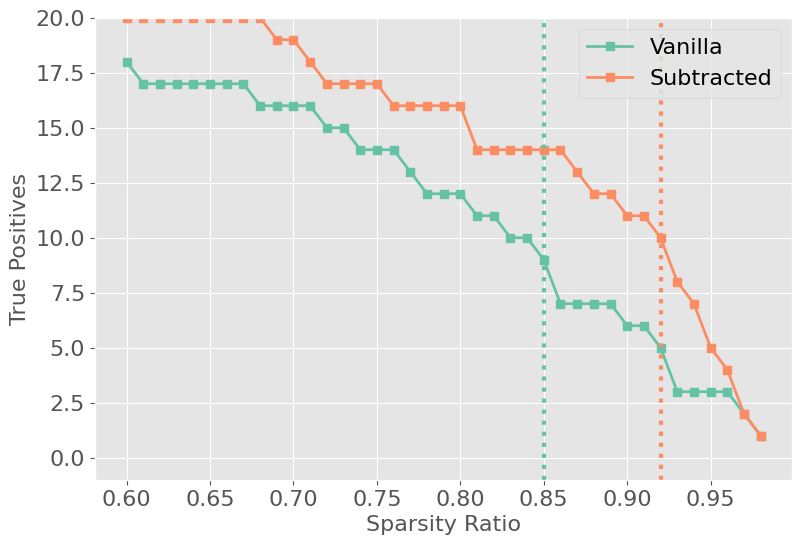

In [29]:
from Pruning.FLAP.lib.FLAP_largeModels import hybrid_FLAP

#lowest_sparsities = [0, 60]
#highest_sparsities = [90, 99]

lowest_sparsities = [60]
highest_sparsities = [99]
cliff_functions =["first"]#["smooth_biggest", "biggest", "smooth_first", "first", "fixed", "detect_cliff", "smooth_detect_cliff"]

#lowest_sparsities = [args.lowest_sparsity]
#highest_sparsities = [args.highest_sparsity]
#cliff_functions = [args.cliff_type]

hybrid_FLAP(
    args=args,
    lowest_sparsities=lowest_sparsities, 
    highest_sparsities=highest_sparsities,
    cliff_functions=cliff_functions
    )

## redownload corrupted files

In [ ]:
from transformers import AutoTokenizer

for use_fast in (True, False):
    try:
        print("Trying use_fast=", use_fast)
        tok = AutoTokenizer.from_pretrained("gpt2", use_fast=use_fast)
        print("Loaded tokenizer OK, pad_token:", tok.pad_token, "eos:", tok.eos_token)
    except Exception as e:
        print("Error with use_fast=", use_fast, "->", repr(e))


In [27]:
from transformers import AutoTokenizer

tok = AutoTokenizer.from_pretrained(
    "gpt2",
    force_download=True,
    cache_dir=None,  # optional, but helps rebuild fresh
)


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

# Look at Attention Pattern

In [9]:
from circuits_PP import IOI_CIRCUIT, choose_circuit, get_manual_PP_circuit
save_path = f"{args.out_path}/{args.model_name}/{args.task}/activations/Subtracted_FLAP"
args.task = "ioi"
CIRCUIT = choose_circuit(args.task, args.model_name)

path /mnt/lustre/work/eickhoff/esx670/res_final//gpt2/ioi/path/automatic/logits_diff/sqrt/min_threshold-0.01/k_2-scale_2.5/


In [50]:
save_path = f"{args.out_path}/{args.model_name}/{args.task}/activations/SubtractedFLAP"


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


load gpt2 tokenizer
load gpt2 as CasualLLM
using gpt2 model in IOI dataset
from 0 to 21
torch.Size([1, 12, 21, 21])


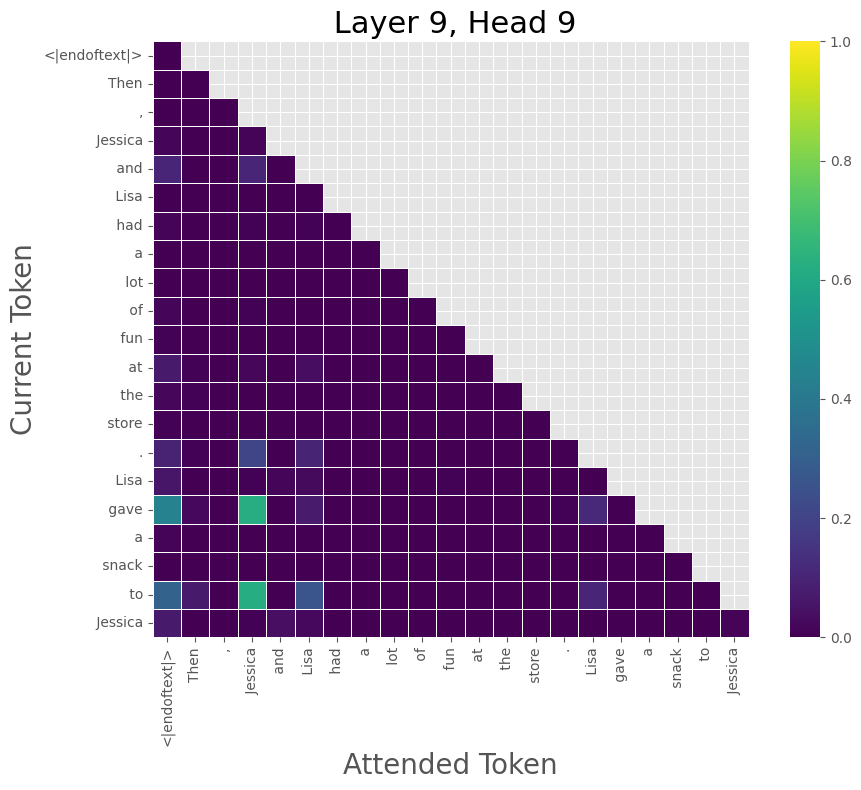

In [60]:
from utils.utils import activation_patterns

tokenizer = load_tokenizer(args.model_name)
args.device="cuda"
model = load_transformer(args.model_name, output_attentions=True, device=args.device, cache_dir=args.cache_dir)
#model=load_hooked_transformer(args.model_name, device=args.device)
args.prepend_bos =False
dataset = load_dataset(
args.task, 
tokenizer,
N =1, 
seed=123443,#args.seed, 
device=args.device, 
model_name=args.model_name, 
prepend_bos=True, 
remove_target_token=False
)

CIRCUIT={9:[9]}
# ----- activation patterns of all elements in a circuit -----
#activation_patterns(model=model, tokenizer=tokenizer, dataset=dataset, CIRCUIT=CIRCUIT)

# ----- activation patterns of specific layer and head elements -----
activation_patterns(
    model=model, 
    tokenizer=tokenizer,
    dataset=dataset,
    CIRCUIT=CIRCUIT,
    activation_type="difference", #"clean", "corrupted", "difference"
    save=False,
    show=True,
    out_path=save_path,
    title=""


) #layer_list=[14] , head_list=[3], is_corrupted=True)

The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


load gpt2 tokenizer
load gpt2 as CasualLLM
Load GreaterThan with gpt2
from 0 to 14
create new path /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/0_1.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/0_5.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/5_1.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/5_5.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/6_9.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activations/difference/diff_activations/7_10.png
save img at /mnt/lustre/work/eickhoff/esx670/res_final/gpt2/GreaterThan/activati

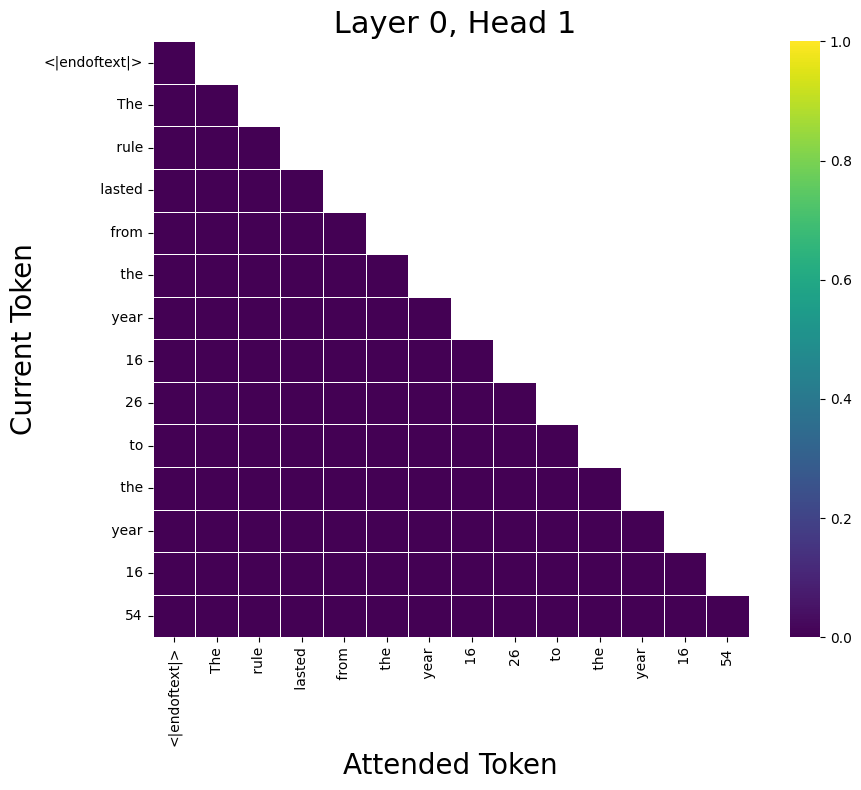

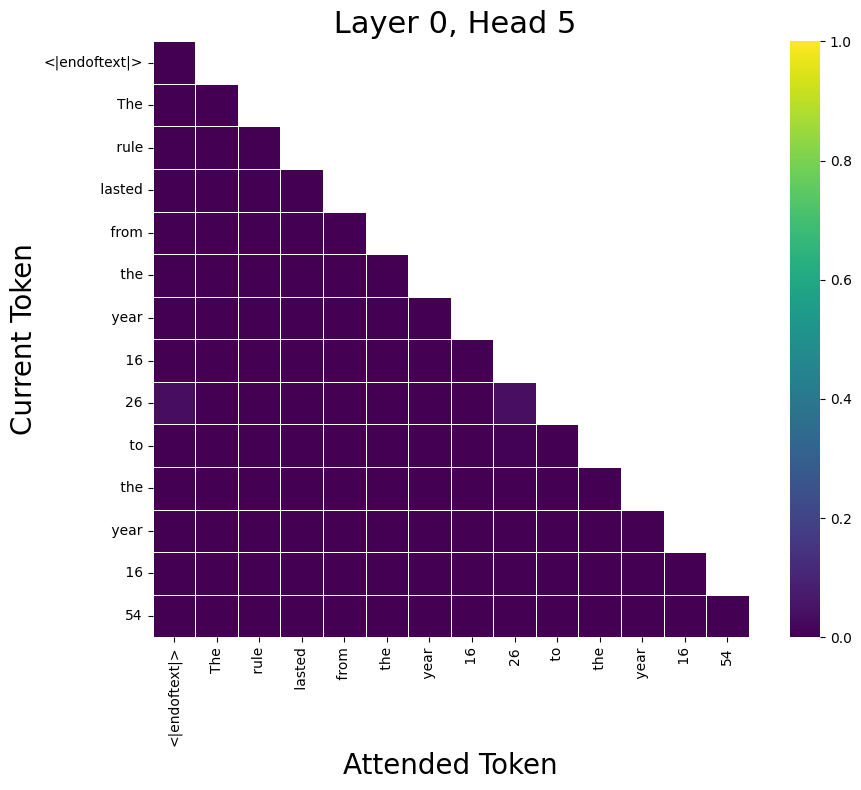

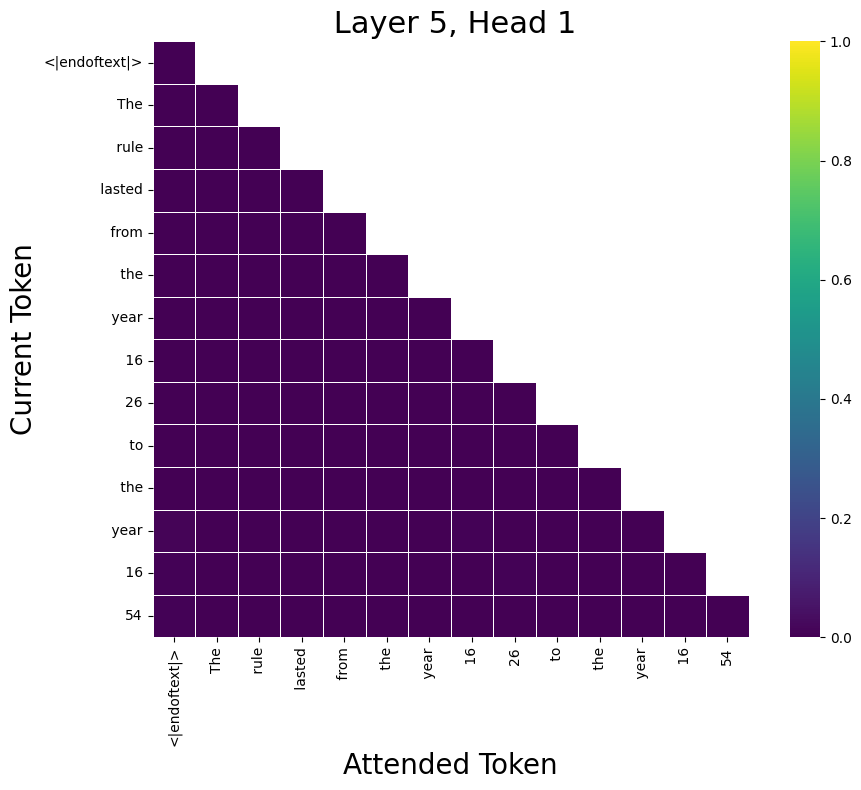

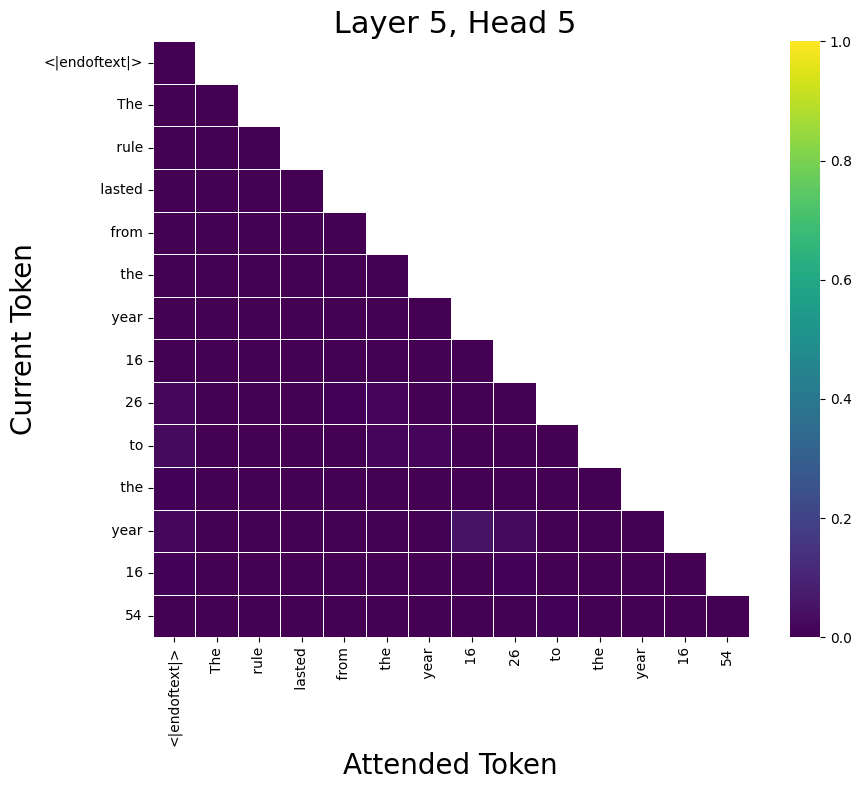

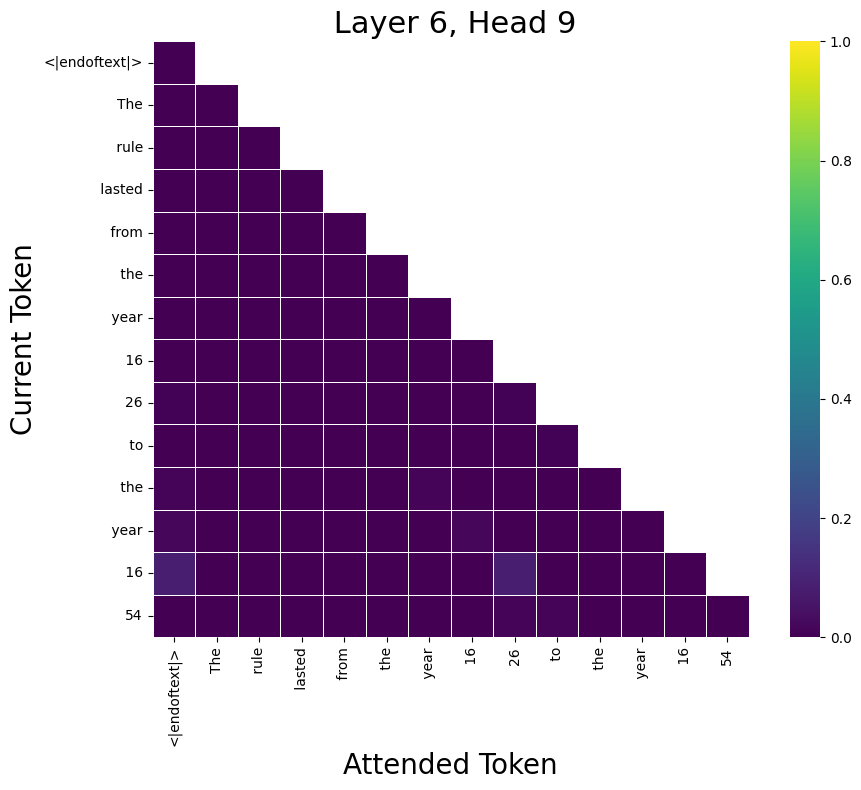

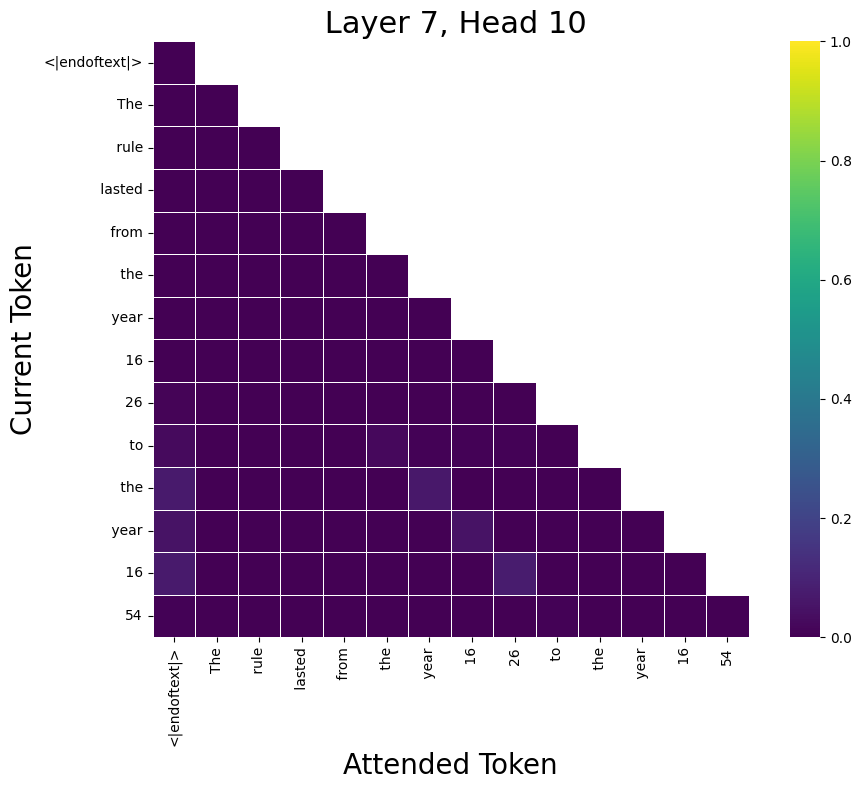

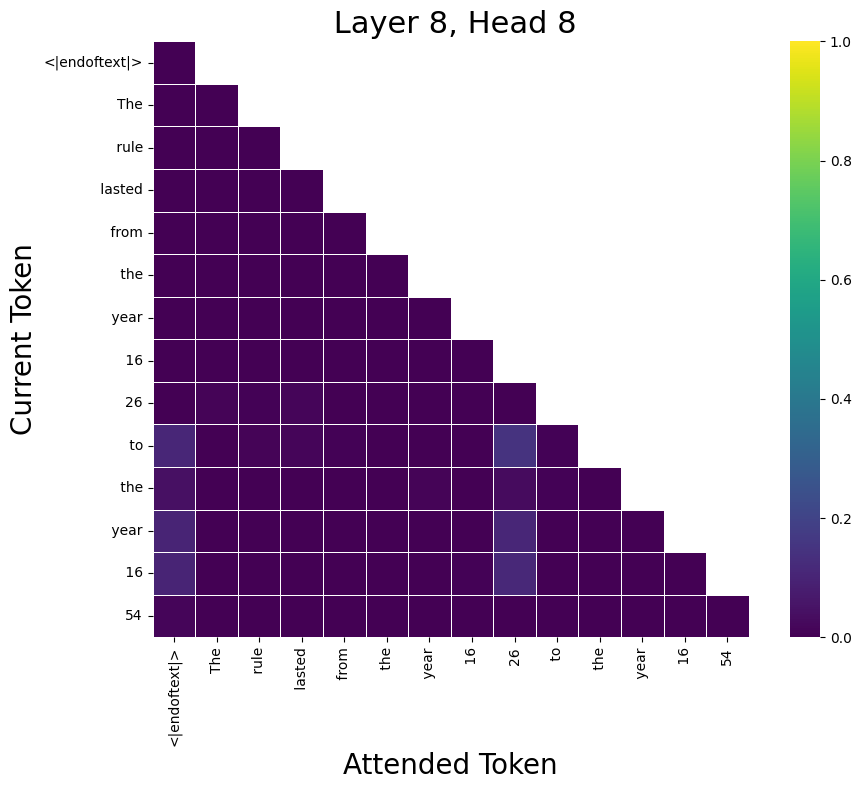

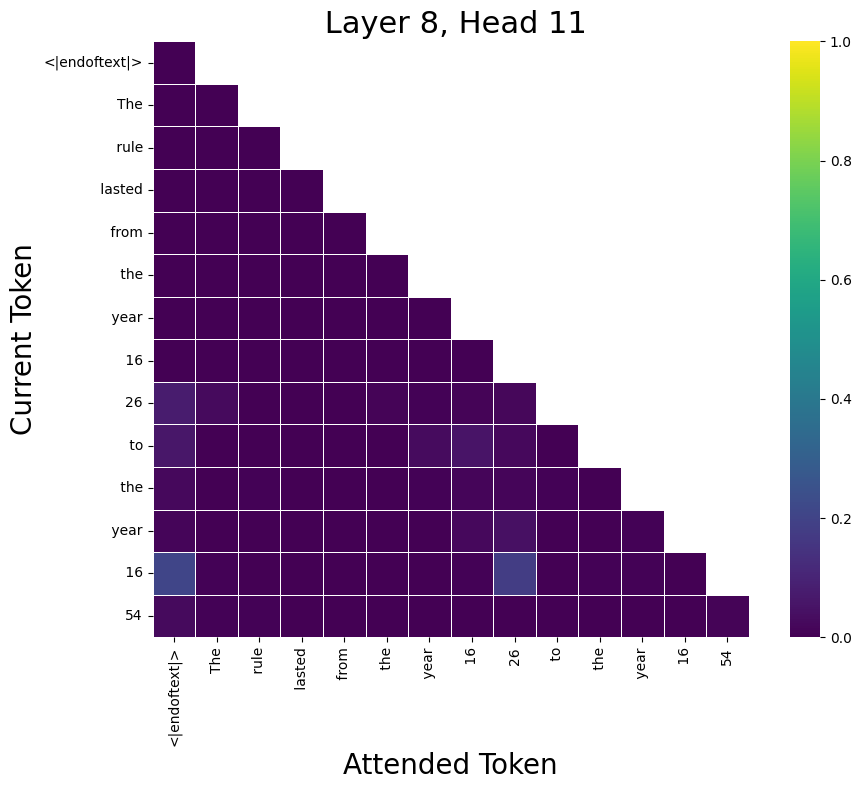

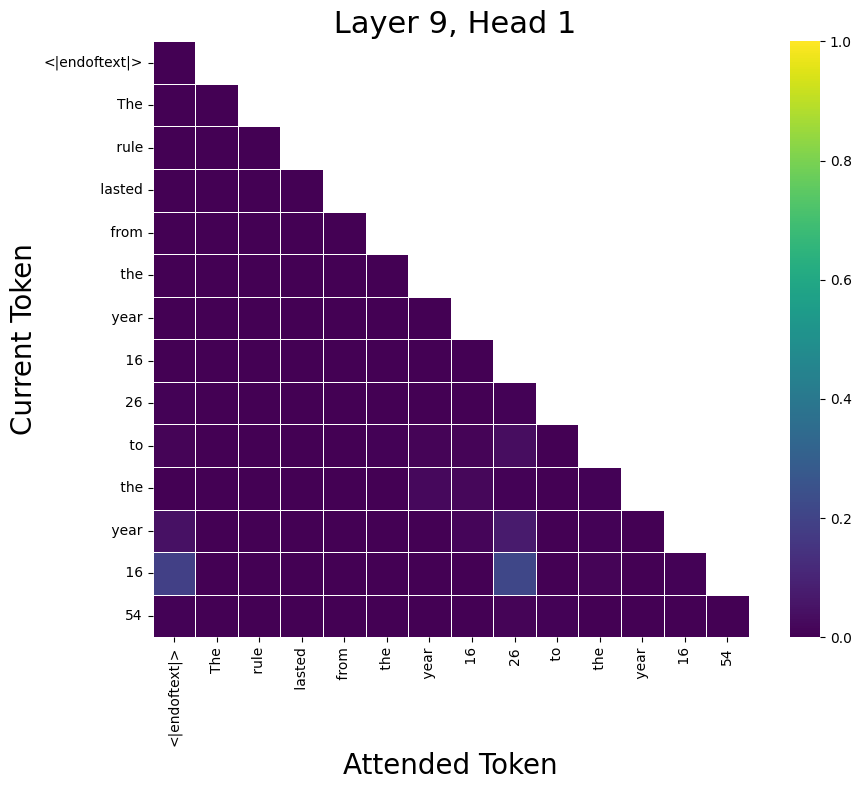

In [ ]:
from utils.utils import activation_patterns
save_path = f"{args.out_path}/{args.model_name}/{args.task}/activations/Path_Patching"
CIRCUIT_ORIG = choose_circuit(args.task, args.model_name)
tokenizer = load_tokenizer(args.model_name)

model = load_transformer(args.model_name, output_attentions=True, device=args.device, cache_dir=args.cache_dir)
#model=load_hooked_transformer(args.model_name, device=args.device)
args.prepend_bos =False
dataset = load_dataset(
    args.task, 
    tokenizer,
    N =1, 
    seed=1233443,#args.seed, 
    device=args.device, 
    model_name=args.model_name, 
    prepend_bos=True, 
    remove_target_token=False
)


# ----- activation patterns of all elements in a circuit -----
#activation_patterns(model=model, tokenizer=tokenizer, dataset=dataset, CIRCUIT=CIRCUIT)

# ----- activation patterns of specific layer and head elements -----
activation_type = "contrastive" #clean "corrupted", "contrastive"
activation_patterns(
    model=model, 
    tokenizer=tokenizer,
    dataset=dataset,
    CIRCUIT=CIRCUIT_ORIG,
    activation_type=activation_type,
    save=True,
    show=True,
    out_path=f"{args.out_path}/{args.model_name}/{args.task}/activations/{activation_type}",
    title=""
    
    
    ) #layer_list=[14] , head_list=[3], is_corrupted=True)